# **Fine Tuning - CIFAR10 on ResNet50 - using TensorFlow with Keras**

In this part, we take pre-trained model **ResNet50** and using **Tranfer Learning** technique to train it on **CIFAR10** dataset.

We performs **Fine Tuning** using **TensoFlow** with **Keras** by **Python**.

ResNet50 Architecture:
![link text](https://miro.medium.com/max/1100/0*9LqUp7XyEx1QNc6A.webp)

## **1. Import Laberies, Load Dataset and Preprocesse the data**

In [ ]:
# importing tensorflow and Keras for doing ML
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.api._v2.keras as keras

from keras import layers
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.models import load_model
from keras.datasets import cifar10
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator

### **Loading our CIFAR-10 Dataset and preprocess it images**


![](https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

In [ ]:
# Define the labels of CIFAR-10 datasest
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Display our data shape/dimensions
print("Data Set:")
print('train samples: ', x_train.shape[0])
print('test samples: ', x_test.shape[0])
print('x_train shape:', x_train.shape)

x_train = np.array([cv2.resize(img, (227, 227)) for img in x_train[:10000]])
x_test = np.array([cv2.resize(img, (227, 227)) for img in x_test[:2000]])
y_train = y_train[:10000]
y_test = y_test[:2000]

print("\nResizing images..")
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

# Now we one hot encode outputs
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

np.random.seed(1000)

x_train type:  <class 'numpy.ndarray'>
X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

### **Display some images from our dataset**

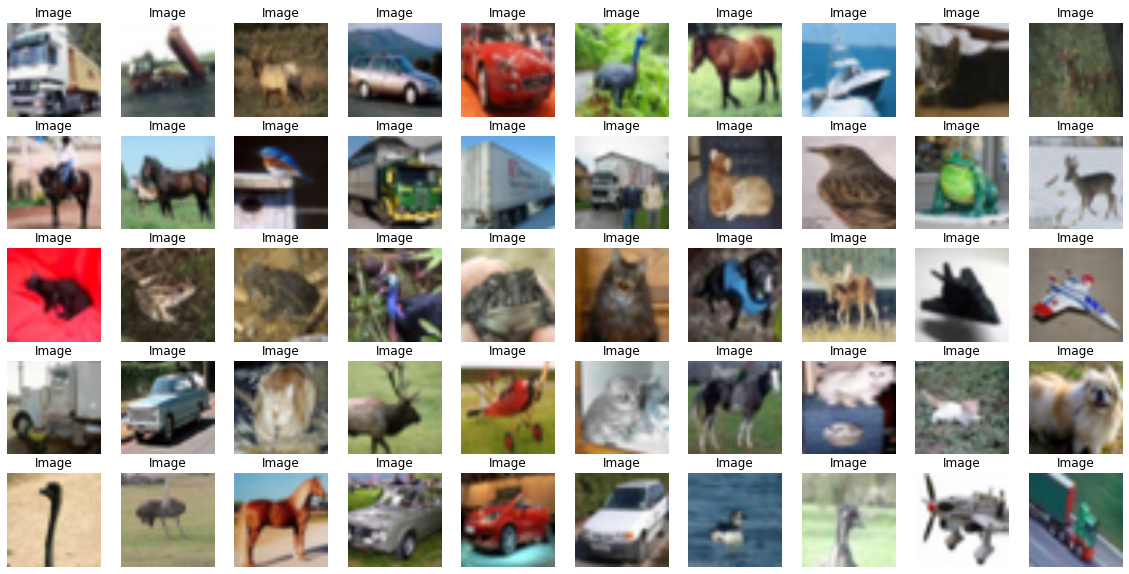

In [ ]:
# Define figure size
plt.figure(figsize=(20,10))

# Define number of images to display
num_of_images = 50


# iterate index from 1 to 51 to show the first 50 images from training dataset
for index in range(1, num_of_images +1):
  plt.subplot(5, 10, index).set_title(labels[np.argmax(y_train[index])])
  plt.axis('off')
  plt.imshow(x_train[index])


## **2. Building The Model**

#### **Load pre-trained ResNet50 Model**

In [ ]:
# Load ResNet50 model without the top and define input shape to (224 X 224 X 3)
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Print the model summary
ResNet50_base_model.summary()

#### **Freezing the base model layers**

In [ ]:
# Create ResNet50 model as type Sequential
last_layer = ResNet50_base_model.get_layer('conv5_block3_out')
last_layer_output = last_layer.output
first_layer_input = ResNet50_base_model.input
ResNet50_model_fnc = tf.keras.Model(first_layer_input, last_layer_output)

# Freezing the train layers in the model
for layer in ResNet50_model_fnc.layers:
   layer.trainable = False

# Print the model summary and type
print(type(ResNet50_model_fnc))
ResNet50_model_fnc.summary()

### **Build our model and fit it to our data set**

In [ ]:
# Create Sequential type model
model = Sequential()

# Add the ResNet50 base model into it
model.add(ResNet50_model_fnc)

# Build the model input
model.build(input_shape) 

# Flatten the last layer of the base model output
model.add(Flatten())

# Build the last layers on the base model and fit it to our dataset 
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, 'softmax'))

# Print the model type and summary
model.summary()

## **3. Training The Model**

#### Now we **unfreeze** the base model and train the entire model end-to-end with low learning rate

In [ ]:
# Make the model trainable
model.trainable = True

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
optimizer = Adam(learning_rate=1e-5)
loss_function = 'categorical_crossentropy'

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Display the model summary
model.summary()

In [ ]:
# Training the model
epochs = 15
batch_size = 64

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks = [es])

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## **4. Reduce overfitting**


### **Now we add a layer of data augmentation to our model and try to increase our result**

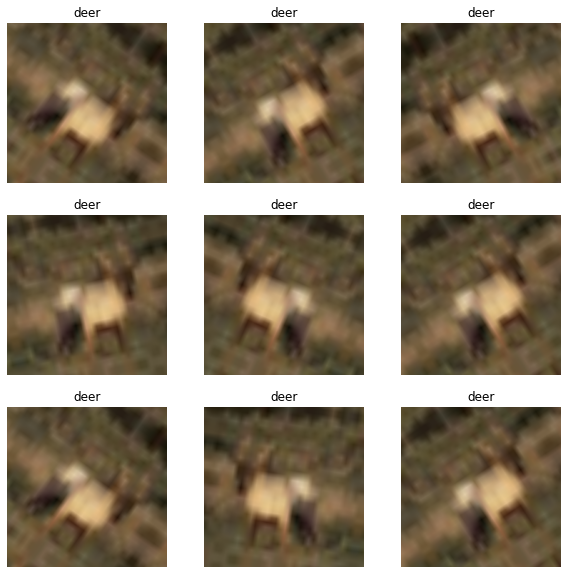

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# Adding Data agumentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

#### **Visualize our Data Augmentation**

In [ ]:
image = np.expand_dims(x_train[3], axis=0)

image = tf.convert_to_tensor(image)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(image, training=True)
    augmented_image = augmented_image[0].numpy().astype("int32")
    # augmented_image = cv2.resize(augmented_image, (32, 32))
    plt.imshow(augmented_image)
    plt.title(labels[np.argmax(y_train[3])])
    plt.axis("off")

In [ ]:
# Create Sequential type model
model_da = Sequential()

# Add data augmentation layer into it
model_da.add(data_augmentation)

# Add the ResNet50 base model into it
model_da.add(ResNet50_model_fnc)

# Build the model input
model_da.build(input_shape) 

# Flatten the last layer of the base model output
model_da.add(Flatten())

# Build the last layers on the base model and fit it to our dataset 
model_da.add(Dense(256, activation='relu'))
model_da.add(BatchNormalization())
model_da.add(Dropout(0.5))
model_da.add(Dense(256, activation='relu'))
model_da.add(BatchNormalization())
model_da.add(Dropout(0.5))
model_da.add(Dense(num_classes, 'softmax'))

# Print the model type and summary
model_da.summary()

In [ ]:
# Make the model trainable
model_da.trainable = True

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=1e-5)

# Compile the model
model_da.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Display the model summary
model_da.summary()

In [ ]:
# Training the model
epochs = 15
batch_size = 64

history = model_da.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks = [es])

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model_da.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### **Implements Data Augmentations with Image Data Generator**

In [ ]:
# Create Sequential type model
model_dag = Sequential()

# Add data augmentation layer into it
model_dag.add(data_augmentation)

# Add the ResNet50 base model into it
model_dag.add(ResNet50_model_fnc)

# Build the model input
model_dag.build(input_shape) 

# Flatten the last layer of the base model output
model_dag.add(Flatten())

# Build the last layers on the base model and fit it to our dataset 
model_dag.add(Dense(256, activation='relu'))
model_dag.add(BatchNormalization())
model_dag.add(Dropout(0.5))
model_dag.add(Dense(256, activation='relu'))
model_dag.add(BatchNormalization())
model_dag.add(Dropout(0.5))
model_dag.add(Dense(num_classes, 'softmax'))

# Print the model type and summary
model_dag.summary()

In [ ]:
# Make the model trainable
model_dag.trainable = True

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=1e-5)

# Compile the model
model_dag.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Display the model summary
model_dag.summary()

In [ ]:
epochs = 10
batch_size = 64

# Define Data Generator for Augmentation
train_datagen = ImageDataGenerator( rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

# Notice we use train_datagen.flow, this takes data & label arrays, generates batches of augmented data.
history = model_dag.fit(train_datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs,
                              validation_data = (x_test, y_test),
                              verbose = 1,
                              steps_per_epoch = x_train.shape[0] // batch_size)

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model_dag.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## **5. Model Performance Analysis**

#### **Ploting our Loss and Accuracy Charts**

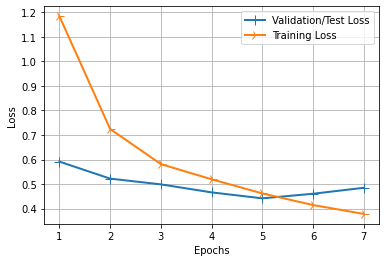

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

# Use the History object we created to get our saved performance results
history_dict = history.history

# Extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

# Plot line charts for both Validation and Training Loss
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

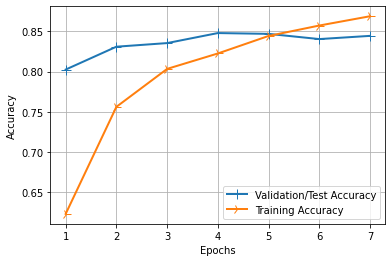

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

#### **Creating our Confusion Matrix**


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

x_test = x_test.reshape(10000, 28, 28, 1) 
y_pred = np.argmax(model_da.predict(x_test), axis=-1)

print(confusion_matrix(y_test, y_pred))

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
target_names = list(range(0,10))
conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat, target_names)

#### **Let's look at our per-class accuracy**

In [ ]:
# Per-class accuracy
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

for (i, classAccuracy) in enumerate(class_accuracy):
    print(f'Accuracy for {labels[i]} : {classAccuracy:.3f}%')

#### **Visualizing the Images Our Model Misclassified**

In [ ]:
import numpy as np

# We reshape our test data
print(x_test.shape)
x_test = x_test.reshape(1000, 227, 227, 3) 
print(x_test.shape)

# Get the predictions for all 10K samples in our test data
print("Predicting classes for all 10,000 test images...")
pred = np.argmax(model_da.predict(x_test), axis=-1)
print("Completed.\n")

# Use numpy to create an array that stores a value of 1 when a misclassification occurs
result = np.absolute(y_test - pred)
misclassified_indices = np.nonzero(0 < result)

#  Display the indices of mislassifications
print(f"Indices of misclassifed data are: \n{misclassified_indices}")
print(len(misclassified_indices[0]))

In [ ]:
sample_test = x_test

plt.figure(figsize=(8, 12))

for cel in misclassified_indices:
    index = misclassified_indices[index]
    image = x_test[index]
    label = labels[y_test[index]]
    predicted = labels[y_pred[index]]
    plt.subplot(6, 3, cel+1)
    plt.imshow(img)
    plt.xlabel("Label: " + label + "Predicted: " + predicted)

plt.tight_layout()
plt.show()

## **6. Save The Model**

In [ ]:
# model.save("cifar10_ResNet50_Fine_Tuning_93.h5")
print("Model Saved")

Model Saved
